# openCV + PyQt5 로 CCTV 만들기

* 난이도 : ★★★★☆☆☆☆☆☆
* 필요라이브러리: PyQt5, openCV, scikit-image


* scikit-image 는 기하학변형, 색공간 조작, 분석, 필터링, 형상감지 등의 알고리즘이 포함된 이미지 처리를 위한 라이브러리 입니다.
> pip install scikit-image


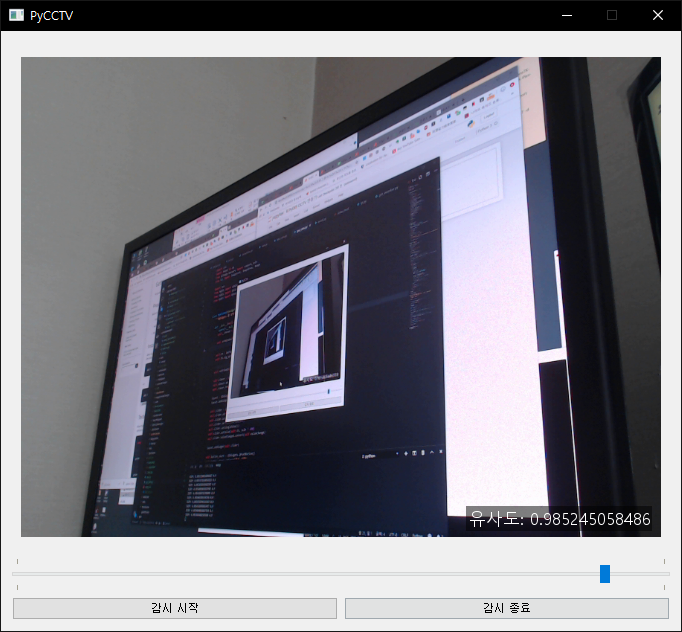


### SSIM 에 대해..
* Struct Similarity (SSIM) 은 두 이미지간 유사도를 측정하는 알고리즘입니다.
* PSNR, MSE 등의 전통적인 방식을 개선하여 설계된 방식입니다.
* VS Code 로 compare_ssim 함수에서 Ctrl + 클릭하면 해당 함수를 직접 살펴보실 수 있습니다.
* 알고리즘에 대해 좀 더 자세히 알고 싶은 분들은 [위키피아](https://en.wikipedia.org/wiki/Structural_similarity) 를 참조해보시길 바랍니다.

In [ ]:
import cv2
import numpy as np
from skimage.measure import compare_ssim
from PIL import ImageFont, ImageDraw, Image

import sys
from PyQt5 import QtWidgets
from PyQt5 import QtCore
from PyQt5 import QtGui

class MyWindow(QtWidgets.QWidget):
    '''QWidgets 를 상속받아 만든 커스텀 윈도우 클래스'''

    def __init__(self):
        '''메인 윈도우의 생성자 함수'''
        super().__init__()

        # 감시 쓰레드가 중지인지 시작인지 판단하는 변수
        # _thread 가 False 가 되면 쓰레드가 종료 됩니다.
        self._thread = False
    
        # 윈도우 타이틀명
        self.setWindowTitle("PyCCTV")

        # Woker 클래스는 QtCore.QThread 를 상속받은 쓰레드 클래스 입니다.
        # QThread 를 이용하지 않고 외부 쓰레드를 직접 구현해서 사용할 경우
        # 시그널이 연속적으로 엄청나게 들어올때 Qt윈도우가 프리징 되는 경우가 생길 수 있습니다.
        # 따라서 안전하게 QThread 를 상속받아 쓰레드로 동작할 Worker 쓰레드를 구현해서 사용해야
        # 시그널을 보내는데 큰 문제가 없습니다.
        self.th = Worker(parent=self)

        # Worker 쓰레드의 시그널과 슬롯(updateWindow)을 연결 합니다.
        self.th.sig_update.connect(self.updateWindow)

        # 윈도우 크기 고정
        self.setFixedSize(680, 600)

        # 웹캠 이미지가 보여질 영역 설정
        self.viewer = QtWidgets.QLabel("이미지 뷰어", self)
        self.viewer.setAlignment(QtCore.Qt.AlignCenter)
        self.viewer.resize(680, 530)
        
        # VBox 레이아웃 생성
        layout = QtWidgets.QVBoxLayout()
        # VBox 레이아웃에 웹캠 이미지가 보여질 QLabel 위젯 추가
        layout.addWidget(self.viewer)

        # 이미지의 유사도를 감지할 값을 직접 설정할 수 있게 슬라이더 생성
        self.slider = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.slider.setFocusPolicy(QtCore.Qt.StrongFocus)
        self.slider.setTickPosition(QtWidgets.QSlider.TicksBothSides)

        # 슬라이더의 간격 설정
        self.slider.setTickInterval(100)
        # 슬라이더의 이동 범위 설정
        self.slider.setSingleStep(1)
        # 슬라이더의 현재 값 설정
        self.slider.setValue(self.th._ssim * 100)
        # 슬라이어가 이동시 연결될 시그널과 슬롯
        self.slider.valueChanged.connect(self.valuechange)

        # 슬라이더를 레이아웃에 추가
        layout.addWidget(self.slider)

        # 감시 시작 버튼 생성 및 시그널 연결
        self.button_start = QtWidgets.QPushButton()
        self.button_start.setText("감시 시작")
        self.button_start.clicked.connect(self.click_start)

        # 김시 종료 버튼 생성 및 시그널 연결
        self.button_stop = QtWidgets.QPushButton()
        self.button_stop.setText("감시 종료")
        self.button_stop.clicked.connect(self.click_stop)

        # 버튼들은 HBox 레이아웃에 추가 
        hbox = QtWidgets.QHBoxLayout()
        hbox.addWidget(self.button_start)
        hbox.addWidget(self.button_stop)

        # 버튼이 추가된 HBox 레이아웃을 VBox 레이아웃에 추가
        layout.addLayout(hbox)

        # 메인 레이아웃에 VBox 레이아웃 설정
        self.setLayout(layout)

        # 윈도우 출력
        self.show()

    def valuechange(self):
        '''슬라이더가 움직였을때 발생되는 슬롯 함수'''
        v = self.slider.value()
        if v > 0:
            v /= 100

        self.th._ssim = v
        print(v)
    
    @QtCore.pyqtSlot(np.ndarray)
    def updateWindow(self, open_cv):
        '''Woker 쓰레드에서 이미지를 실제 메인 윈도우로 출력 할 슬롯 함수
        Woker 쓰레드에서 보내는 이미지는 opencv 이미지로 이 함수에서 받아서
        QLabel 에 출력 가능하게 QPixmap 으로 변환하여 QLabel 에 출력 합니다.'''

        # 넘어온 opencv 이미지의 w, h 을 구합니다.
        w = open_cv.shape[1]
        h = open_cv.shape[0]

        # 최종 이미지를 출력하기 위해 RGB로 다시 변경
        open_cv = cv2.cvtColor(open_cv, cv2.COLOR_BGR2RGB)
        # PyQt에서 출력가능하게 opencv -> QImage로 변경
        qImg = QtGui.QImage(open_cv.data, w, h, 3 * w, QtGui.QImage.Format_RGB888)
        pixmap01 = QtGui.QPixmap.fromImage(qImg)

        # 이미지 출력
        self.viewer.setPixmap(pixmap01)

    def click_start(self):
        '''감시 시작 버튼 클릭시'''

        # 현재 쓰레드가 종료 중이면
        if not self._thread:
            # 쓰레드를 진행중으로 설정하고
            self.th._thread = True
            # 쓰레드 시작
            self.th.start()

    def click_stop(self):
        '''감시 중지 버튼 클릭시'''
        # 쓰레드 상태 변수를 False 로 설정
        self.th._thread = False
        print("종료 {}".format(self.th._thread))

    def keyPressEvent(self, e):
        '''키보드가 입력되면 호출 되는 오버라이딩 함수

        Args:
            e (PyQt5.QtGui.QKeyEvent) : 키보드 이벤트

        참조: https://www.riverbankcomputing.com/static/Docs/PyQt5/api/qtgui/qkeyevent.html?highlight=qkeyevent#PyQt5.QtGui.QKeyEvent
        '''

        # 입력된 키보드의 키가 esc 키면 프로그램 종료
        if e.key() == QtCore.Qt.Key_Escape:
            self.close()

     
class Worker(QtCore.QThread):
    '''PyQt에서 사용할 쓰레드 클래스
        QThread 를 이용하지 않고 외부 쓰레드를 직접 구현해서 사용할 경우
        sig_update 시그널을 메인 윈도우쪽으로 엄청나게 보낼텐데
        그때 메인 Qt윈도우가 프리징 되는 경우가 생길 수 있습니다.
        따라서 안전하게 QThread 를 상속받아 쓰레드로 동작할 Worker 쓰레드를 구현해서 사용해야
        시그널을 보내는데 큰 문제가 없습니다.'''

    # 쓰레드에서 본체 프로그램쪽으로 무언가 신호를 보낼 시그널
    # 시그널 전송시 인자값은 opencv 이미지 자체를 보냅니다.
    sig_update = QtCore.pyqtSignal(np.ndarray)

    def __init__(self, parent=None):
        '''Woker 클래스 생성자 함수'''

        # 부모 QThread 클래스 생성자 호출 
        super().__init__()
        # 쓰레드 상태 변수
        self._thread = True
        # 이미지 유사도 설정값 (이 값 이하면 변화라고 감지함)
        self._ssim = 0.90

    def run(self):
        '''run 함수는 부모클래스인 QThread 클래스의 오버라이딩 된 함수 입니다.'''

        # 웹캠 캡쳐 오픈
        cap = cv2.VideoCapture(0)
        
        # 웹캠 사용가능한지 체크
        if (cap.isOpened() == False): 
            print("카메라를 오픈할 수 없습니다.")
        
        # 연결된 웹캠 디바이스의 프레임 해상도를 알아옵니다.
        # float 를 int 로 캐스팅 해야 합니다.
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        
        # 웹캠의 내용을 파일로 저장하기 위해 VideoWriter 를 설정합니다.
        # 여기서 'M', 'J', 'P', 'G' 는 MotionJPEG 코덱을 사용한다는 이야기인데
        # D I V X 같은 코덱도 해당 컴퓨터에 설치 되어있으면 사용할 수 있습니다.
        out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

        # 이미지 변화를 감지하기 위해 저장해놓을 이전 이미지 변수
        old_image = None

        # 화면 변화 감지시 빨간색 박스를 그리기 위해 (BGR)
        c = (0, 0, 255)

        # 무한루프
        while(self._thread):
            # 웹캠 장치에서 프레임을 읽어옵니다.
            ret, frame = cap.read()
            src = frame.copy()
        
            # 프레임 읽기에 성공하면
            if ret == True: 
                # 현재 프레임의 width, height 을 구합니다.
                w = frame.shape[1]
                h = frame.shape[0]
                
                # 파일로 저장합니다.
                out.write(frame)

                # 이전 이미지가 존재한다면
                if old_image is not None:
                    # 현재 이미지와 이전 이미지를 흑백으로 변환합니다.
                    grayA = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
                    grayB = cv2.cvtColor(old_image, cv2.COLOR_BGR2GRAY)

                    # 사이킷 이미지의 compare_ssim 함수를 사용하여
                    # 이미지의 유사도를 측정합니다.
                    (score, diff) = compare_ssim(grayA, grayB, full=True)
                    diff = (diff * 255).astype("uint8")
                    print("SSIM: {} {}".format(score, self._ssim))

                    # 이미지에 유사도를 출력
                    frame = self.make_text(frame, "유사도: {:.12f}".format(score))

                    # 이미지 유사도가 xxx이하면
                    if score < self._ssim:
                        # 이미지에 6 두께의 빨간 사각형을 그립니다.
                        cv2.rectangle(frame, (0, 0), (w, h), c, 6)

                # 다음 프레임 비교를 위해 현재 프레임을 이전 이미지 변수에 저장
                old_image = src

                # 메인 윈도우로 시그널을 보냅니다.
                self.sig_update.emit(frame)

                # Q 키 누르면 종료합니다.
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            # 프레임 읽기 실패시 종료
            else:
                break 
        
        # 웹캠 장치와 파일저장을 모두 종료시킵니다.
        cap.release()
        out.release()
        
        # opencv 로 생성된 창을 모두 삭제 합니다.
        cv2.destroyAllWindows()

    def make_text(self, img, text):
        '''이미지 우하단에 텍스트를 작성하는 함수
        opencv 에서 제공하는 텍스트는 기능이 너무 제한적이라 pillow 로 텍스트를 작성합니다.
        Args:
            img (openc_cv) : opencv 이미지
            text (str) : 텍스트
        
        Returns:
            opencv : 텍스트가 작성된
        '''

        # 폰트명과 사이즈를 인자로 넘겨줘 PIL 의 ImageFont 객체 생성
        font = ImageFont.truetype("malgun.ttf", 17)
        
        # 해당 텍스트의 영역을 구합니다.
        text_w, text_h = font.getsize(text)

        # 이미지의 w, h 
        w = img.shape[1]
        h = img.shape[0]

        # 텍스트가 실제 이미지에 위치할 위치값 계산
        X_POS = w - text_w - 10
        Y_POS = h - text_h - 10
        
        # 이미지의 텍스트 영역에 투명 사각형을 그리기 위해서는 오버레이 처리를 해야합니다.
        # 먼저 원본 이미지의 복사본을 생성
        overlay = img.copy()
        
        # 복사본 이미지의 텍스트 영역에 사각형을 Fill 형태로 채웁니다.
        cv2.rectangle(overlay, (X_POS - 3, Y_POS), (X_POS + text_w, Y_POS + text_h + 3), (0, 0, 0), -1)

        # 사각형의 투명도를 설정합니다.
        alpha = 0.5 
        
        # 원본이미지와 복사본 이미지를 합칩니다.
        # addWeighted 함수는 이미지를 합칠시에 가중치를 주어 합치는 방식인데
        # 여기서는 alpha 값만큼을 1-alpha 값만큼으로 합치게 되니 실제 투명박스 부분만 합쳐지게 됩니다. 
        img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

        # opencv -> pillow
        img_pil = Image.fromarray(img)

        # pillow 이미지로 draw 객체는 생성합니다.
        draw = ImageDraw.Draw(img_pil)
        
        # 이미지에 텍스트를 작성합니다.
        draw.text((X_POS, Y_POS), text, (255,255,255), font=font)

        # pillow -> opencv    
        img = np.array(img_pil)

        return img

if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv)
    win = MyWindow()
    sys.exit(app.exec_())